# U.S. Medical Insurance Costs

Note, for this work $\alpha = 0.05$ will be used.

In [75]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression as LR
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_error as mae
from sklearn.svm import LinearSVR, SVR
from sklearn.kernel_ridge import KernelRidge
import warnings
warnings.filterwarnings("ignore")
sns.set_theme()

In [76]:
df = pd.read_csv("insurance.csv")

In [77]:
display(df.head())

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## INITIAL EDA

In [78]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


No nulls.
Lets check for incorrectly entered data.

In [79]:
print('Number of entries with 0 bmi: {}'.format(df[df['bmi'] == 0].shape[0]))
print('Number of entries with age < 18: {}'.format(df[df['age'] < 18].shape[0]))
print('Number of entries with 0 charges: {}'.format(df[df['charges'] == 0].shape[0]))


Number of entries with 0 bmi: 0
Number of entries with age < 18: 0
Number of entries with 0 charges: 0


Every entry in our data set has a valid bmi, age and charge. We will consider the data clean.

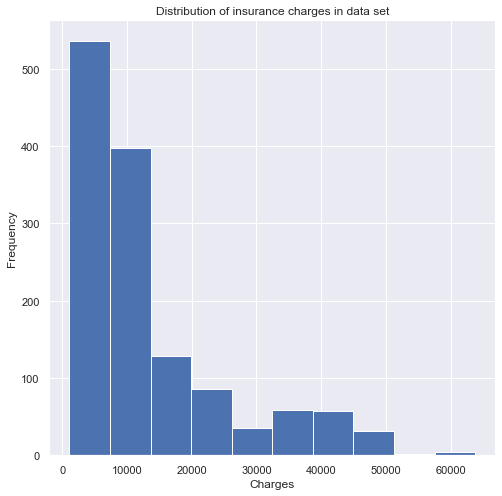

In [80]:
plt.hist(df['charges'])
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.title('Distribution of insurance charges in data set')
plt.show()

Non-normal distributution, but we have a large number data points. Will have an impact of statistical tests

In [81]:
display(df['sex'].value_counts())

male      676
female    662
Name: sex, dtype: int64

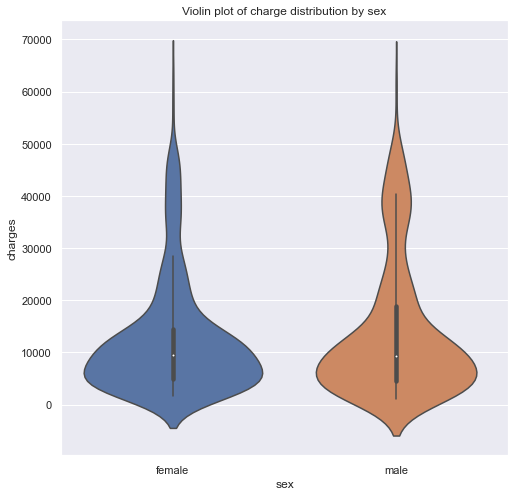

In [82]:
sns.violinplot(x = 'sex',y='charges', data = df)
plt.title('Violin plot of charge distribution by sex')
plt.show()

In [83]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

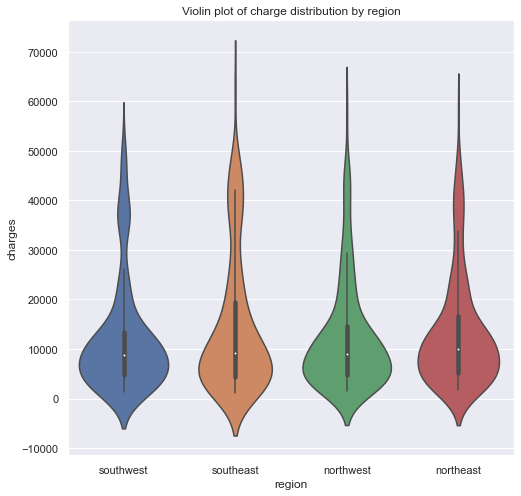

In [84]:
sns.violinplot(x='region', y = 'charges', data = df)
plt.title('Violin plot of charge distribution by region')
plt.show()

Fairly equal representations of both sexes and all four regions. Neither seem to have important relationships with the insurance charges.

In [85]:
df['children'].value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

,children,age,bmi,charges
0,0,38.444251,30.550296,12365.975602
1,1,39.453704,30.623148,12731.171832
2,2,39.445833,30.978104,15073.563734
3,3,41.566879,30.684331,15355.318367
4,4,39.000000,31.391200,13850.656311
5,5,35.611111,29.605000,8786.035247


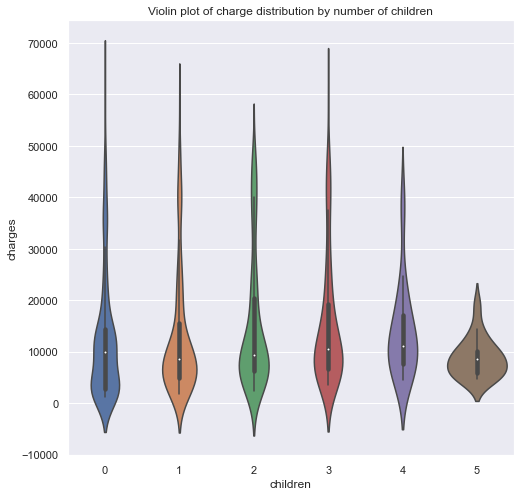

In [86]:
child_df = df.groupby('children', as_index = False).mean()
display(child_df)
sns.violinplot(x='children', y = 'charges', data = df)
plt.title('Violin plot of charge distribution by number of children')
plt.show()

More people in dataset with less children. Have the acknowledge that 4 and 5 children people are under represented in this data set. People with 2 or 3 children seem to pay more than the rest, will investigate further.

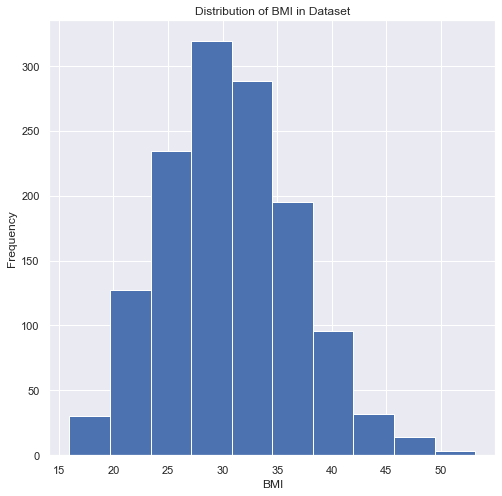

In [87]:
plt.hist(df['bmi'])
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.title('Distribution of BMI in Dataset')
plt.show()

Normally distributed BMI. Peak at around 30, the threshold for obesity. Close to real US distribution (https://www.niddk.nih.gov/health-information/health-statistics/overweight-obesity).

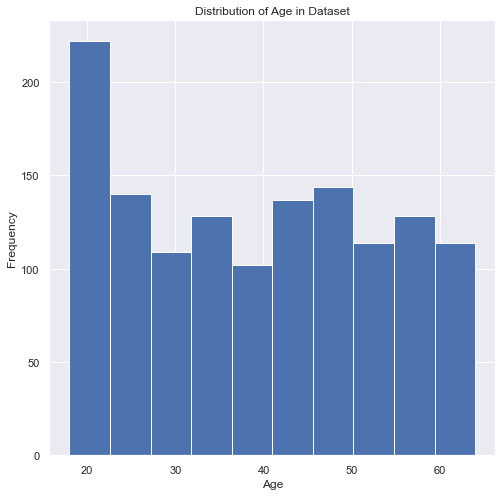

In [88]:
plt.hist(df['age'])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age in Dataset')
plt.show()

More young people (~20 years old) in the data set than other category. This is not representative of the general population of America, which has peaks in the 25-29 and 55-59 brackets (https://www.statista.com/statistics/241488/population-of-the-us-by-sex-and-age/). Might need to account for this bias.

In [89]:
num_df_corr = df.corr()
print('Correlation of numerical variable with insurance charge')
display(num_df_corr['charges'])

Correlation of numerical variable with insurance charge


age         0.299008
bmi         0.198341
children    0.067998
charges     1.000000
Name: charges, dtype: float64

Age and bmi correlate positively with charges, so these should be investigated further. This suggests that number of children has no impact, but we say previously that it was not a linear relationship (e.g. people with 2 or 3 children payed more than those with none or 5).

In [90]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

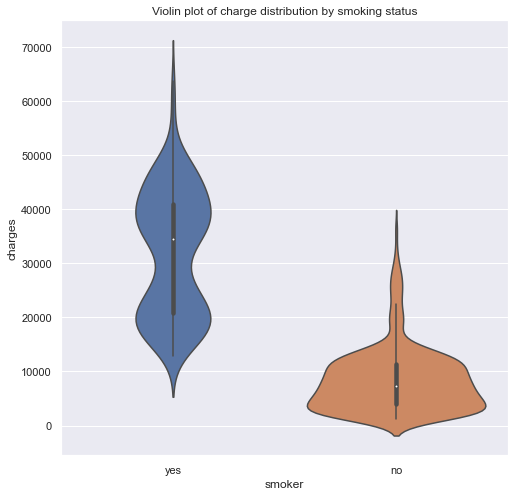

In [91]:
sns.violinplot(x='smoker', y = 'charges', data = df)
plt.title('Violin plot of charge distribution by smoking status')
plt.show()

Smoking appears to greatly increase the cost of insurance, investigate this further as well. However should note that smokers are over represented in this data set, the set is roughly 20% smokers, whereas the national rate in the US is 12.5% (https://www.cdc.gov/tobacco/data_statistics/fact_sheets/adult_data/cig_smoking/index.htm).

### Initial findings

Representation in the set:
 - gender and location are equally represented
 - bmi distribution reflect US population
 - young people and smokers are over-represented

Impact on insurance charges
 - bmi 
 - smoking status 
 - age 
 - number of children


We will now investigate the factors affecting insurance charges in more detail.

## SMOKING DEPENDANCE

First lets look at the impact of smoking on the cost of insurance.

In [92]:
smoke_df  = df.groupby('smoker').mean()
mean_charge_smoker = smoke_df['charges'][1]
mean_charge_nonsmoker = smoke_df['charges'][0]
diff_smoker = mean_charge_smoker - mean_charge_nonsmoker
sd = df['charges'].std()
num_sd_smoker_diff = diff_smoker/sd
print('Average insurance cost for smoker: ${:.2f}'.format(mean_charge_smoker))
print('Average insurance cost for non-smoker: ${:.2f}'.format(mean_charge_nonsmoker))
print('Number of standard deviations of charge increase if smoker: {}'.format(num_sd_smoker_diff))
print('Percentage increase in charge if smoker: {:.2f} %'.format(mean_charge_smoker/mean_charge_nonsmoker*100-100))

Average insurance cost for smoker: $32050.23
Average insurance cost for non-smoker: $8434.27
Number of standard deviations of charge increase if smoker: 1.950119043830363
Percentage increase in charge if smoker: 280.00 %


Clearly a large increase in cost for smokers. Lets check the distributions before we do any statistical testing. 

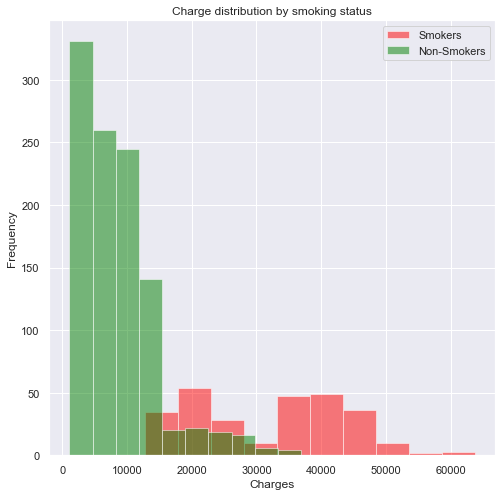

In [93]:
smoker_charges = df[ df['smoker'] == 'yes']['charges'].to_numpy()
nonsmoker_charges = df[ df['smoker'] == 'no']['charges'].to_numpy()
plt.hist(smoker_charges,color ='red', alpha = 0.5, label = 'Smokers')
plt.hist(nonsmoker_charges,color ='green', alpha = 0.5, label = 'Non-Smokers')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.title('Charge distribution by smoking status')
plt.legend()
plt.show()

The two populations are not normally distributed, and have unequal sizes. This suggests a non-parametrized test for significance for the difference of the two population means. However as we have a decently sized sample, we can try a ttest as well. First lets compare the variance of the two populations.

In [94]:
smoker_charges = df[ df['smoker'] == 'yes']['charges'].to_numpy()
nonsmoker_charges = df[ df['smoker'] == 'no']['charges'].to_numpy()
print('Smoker charge variance: {}\nNon smoker charge variance: {}'.format(smoker_charges.std(),nonsmoker_charges.std()) )

Smoker charge variance: 11520.46670652943
Non smoker charge variance: 5990.9645302876115


Unequal variance, so will use Welch's t-test to start, robust to difference variance and population sizes. The null hypothesis is that the two means are equal, and the alternate is that the charges for smokers are larger.

In [95]:
stats.ttest_ind(smoker_charges,nonsmoker_charges, alternative = 'greater', equal_var = False)

Ttest_indResult(statistic=32.751887766341824, pvalue=2.94473222335849e-103)

Suggests the increase in insurance charges for smokers is significant ($p = 10^{-103}$). Lets back up this result with non-parametric test, Mann-Whitney U. The null hypothesis is that the underlying distributions are the same, with for example the same location.

In [96]:
stats.mannwhitneyu(smoker_charges,nonsmoker_charges, alternative = 'greater') 

MannwhitneyuResult(statistic=284133.0, pvalue=2.6351167222517853e-130)

This result ($p = 10^{-130}$) confirms that we can reject the null hypothesis and that the increase in insurance charges for smokers is statistically significant.

### Smokers findings
There is a 280% increase in insurance charges for people who smoke. This increase is significant as per testing above.

## AGE DEPENDANCE


We previously found a positive correlation between age and charges. Lets first plot charges as a function of age to try understand this relationship better.

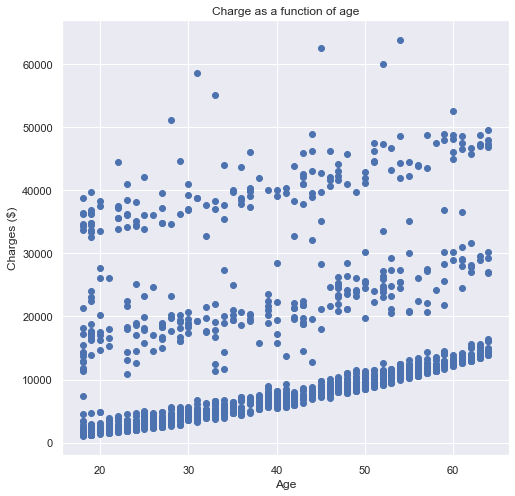

In [97]:
age_vector = df['age'].to_numpy()
charge_vector = df['charges'].to_numpy()
plt.scatter(age_vector, charge_vector)
plt.xlabel('Age')
plt.ylabel('Charges ($)')
plt.title('Charge as a function of age')
plt.show()

There is a clear increase with age, with the minimum insurance charge increasing monotonically with age. However there are two rough tiers of higher charges, we will try to determine the causes of these.

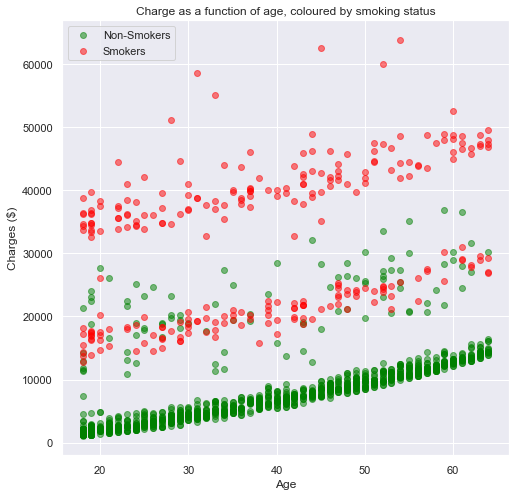

In [98]:
smoking_boolean = df['smoker'] == 'yes'
nonsmoking_boolean = df['smoker'] == 'no'
plt.scatter(age_vector[nonsmoking_boolean], charge_vector[nonsmoking_boolean], c= 'green', label='Non-Smokers', alpha = 0.5)
plt.scatter(age_vector[smoking_boolean], charge_vector[smoking_boolean], c= 'red', label='Smokers', alpha = 0.5)
plt.xlabel('Age')
plt.ylabel('Charges ($)')
plt.legend()
plt.title('Charge as a function of age, coloured by smoking status')
plt.show()

Clearly shown that age increases the charges in general, and that smoking status can account for some of the higher tiers, however there must be other factors at play.

## BMI

Maybe this is another factor for increased charges, as it was found to positively correlate with charges in our EDA.

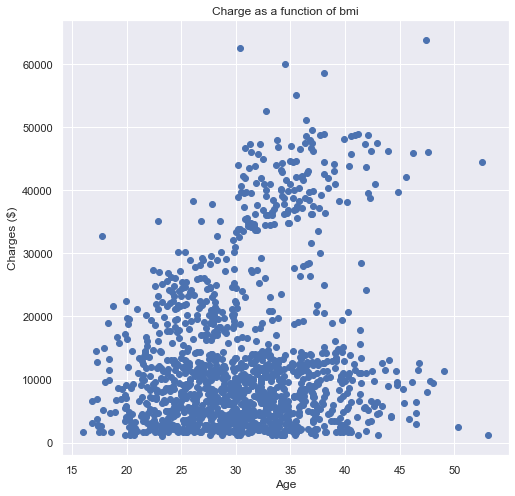

In [99]:
bmis = df['bmi']
plt.scatter(bmis, charge_vector)
plt.xlabel('Age')
plt.ylabel('Charges ($)')
plt.title('Charge as a function of bmi')
plt.show()

Does not seem to be a strong relationship between bmi and charges, as many high bmi people pay the same. However, there does appear to be a threshold at around 30, the bmi for obesity. So lets quickly look at this.

First we will add some tiering to the BMI, using the standard thresholds from the CDC:
- $<18.5$ underweight
- $18.5 - <25$ healthy
- $25- <30$ overweight
- $>30$ obese

In [100]:
# Helper function to assign a bmi tier based on bmi
def bmi(bmi:int) -> str:
    if bmi < 18.5: return 'Underweight'
    elif bmi < 25: return 'Healthy'
    elif bmi < 30: return 'Overweight'
    else: return 'Obese'

#Assign BMI tiering to new column.
df['BMI_Tier'] = df['bmi'].apply(bmi)
display(df.head())

,age,sex,bmi,children,smoker,region,charges,BMI_Tier
0,19,female,27.900,0,yes,southwest,16884.92400,Overweight
1,18,male,33.770,1,no,southeast,1725.55230,Obese
2,28,male,33.000,3,no,southeast,4449.46200,Obese
3,33,male,22.705,0,no,northwest,21984.47061,Healthy
4,32,male,28.880,0,no,northwest,3866.85520,Overweight


Now we can analyse the effect of BMI tier on insurance charges.

In [101]:
bmi_df = df.groupby('BMI_Tier', as_index = False).mean()
display(bmi_df)
display(df['BMI_Tier'].value_counts())
print('Increase in charges due to obesity compared to healthy: {:.2f} %'.format(bmi_df['charges'][1]/bmi_df['charges'][0]*100-100))

,BMI_Tier,age,bmi,children,charges
0,Healthy,36.733333,22.616133,1.128889,10409.337709
1,Obese,40.343706,35.266011,1.106082,15552.335469
2,Overweight,38.922280,27.602591,1.056995,10987.509891
3,Underweight,32.350000,17.566250,1.050000,8852.200585


Obese          707
Overweight     386
Healthy        225
Underweight     20
Name: BMI_Tier, dtype: int64

Increase in charges due to obesity compared to healthy: 49.41 %


A clear increase in charges for obese people and a decrease for underweight people, compared to healthy and overweight people. Lets check if the increase for obese people is significant. As with the US population, obese people account for half the data set. First we again check the distributions.

In [102]:
obese_boolean = df['BMI_Tier'] == 'Obese'
nonobese_boolean = df['BMI_Tier'] != 'Obese'

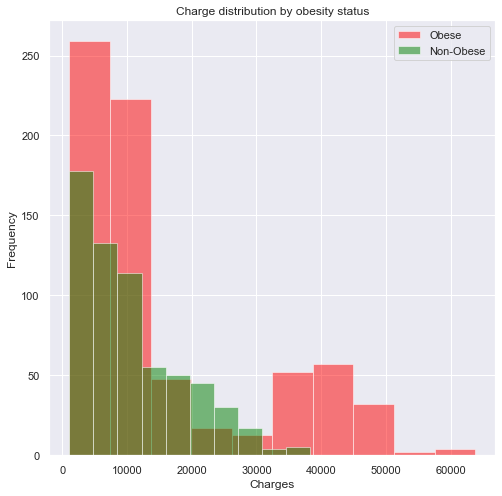

In [103]:
obese_charges = charge_vector[obese_boolean]
nonobese_charges = charge_vector[nonobese_boolean]
plt.hist(obese_charges,color ='red', alpha = 0.5, label = 'Obese')
plt.hist(nonobese_charges,color ='green', alpha = 0.5, label = 'Non-Obese')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.title('Charge distribution by obesity status')
plt.legend()
plt.show()

Once again we have non-normal distributions, with unequal sample sizes and unequal variances (by inspection), so lets again use our two statistical tests to determine the significance of the change in charges due to being obese. These are again one sided tests with the null being the means are the same, and the alternate hypothesis that the obesity charges have a higher mean.

In [104]:
# Welch's t-test
stats.ttest_ind(obese_charges,nonobese_charges, alternative = 'greater', equal_var = False)

Ttest_indResult(statistic=7.679158554353561, pvalue=1.7520024527809808e-14)

In [105]:
# Mann-Whitney U
stats.mannwhitneyu(obese_charges,nonobese_charges, alternative = 'greater') 

MannwhitneyuResult(statistic=250364.0, pvalue=5.440342798784988e-05)

Both these results suggest the increase in insurance charges with obesity is significant, with $ p = 10^{-14}$ for Welch's and $p = 10^{-5}$ for Mann Whitney. So we can reject the null hypothesis.

However we must note that the distribution above suggests that obesity does not always preclude higher charges, as there are a large number of obese people paying close to the minimum.

So obesity is another factor causing increase in charges (significant increase). Does this explain the other gradations in the age vs charge plot?

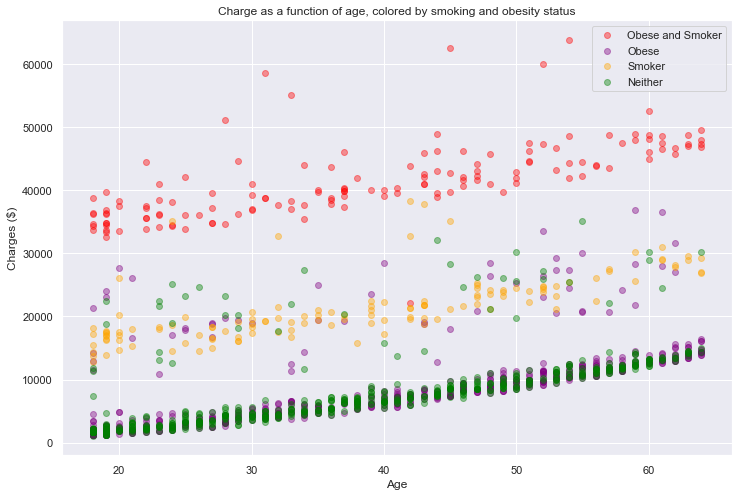

In [106]:
smoker_obese_boolean = obese_boolean & smoking_boolean
nonsmoker_obese_boolean = obese_boolean & nonsmoking_boolean
smoker_nonobese_boolean = nonobese_boolean & smoking_boolean
nonsmoker_nonobese_boolean = nonobese_boolean & nonsmoking_boolean
plt.rcParams['figure.figsize'] = [12, 8]
plt.scatter(age_vector[smoker_obese_boolean], charge_vector[smoker_obese_boolean], c = 'red', label='Obese and Smoker', alpha = 0.4)
plt.scatter(age_vector[nonsmoker_obese_boolean], charge_vector[nonsmoker_obese_boolean], c= 'purple', label='Obese', alpha = 0.4)
plt.scatter(age_vector[smoker_nonobese_boolean], charge_vector[smoker_nonobese_boolean], c= 'orange', label='Smoker', alpha = 0.4)
plt.scatter(age_vector[nonsmoker_nonobese_boolean], charge_vector[nonsmoker_nonobese_boolean], c= 'green', label='Neither', alpha = 0.4)
plt.xlabel('Age')
plt.ylabel('Charges ($)')
plt.title('Charge as a function of age, colored by smoking and obesity status')
plt.legend()
plt.show()

In [107]:
print('Increase in charges for those who smoke and are obese compared to those who are neither: {:.2f} %'
    .format(charge_vector[smoker_obese_boolean].mean()/charge_vector[nonsmoker_nonobese_boolean].mean()*100 - 100))

Increase in charges for those who smoke and are obese compared to those who are neither: 420.97 %


People who smoke and are obese almost exclusively make up the top band. These two statuses in combination cause insurance costs to increase by 420%. The middle tier is made up mostly of people who smoke or are obese, but there are still some unexplained people who are neither smokers nor obese in this band. Finally, as previously noted, obesity does not guarantee higher rates, as there are obese people in the bottom charge tier, however smoking almost guarantees that a person will pay a higher price for insurance.

## CHILDREN


As a final investigation lets look at the impact of children on insurance prices.

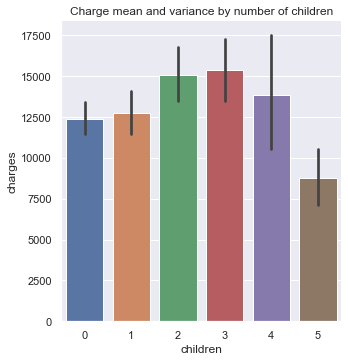

In [108]:
sns.catplot(data=df, kind="bar", x="children", y="charges")
plt.title('Charge mean and variance by number of children')
plt.show()

From the above figure it appears that having 1 child does not increase premiums, however 2 or 3 do, 4 seems to slightly increase premiums however this category has a large variance. Having 5 children greatly reduces premiums. 

Can people with 2 or 3 children make up the rest of the middle band in the age vs charge plot?

We will remove smokers and obese people from the set and look at the effect of just children.

In [109]:
healthy_df = df[ (df['smoker'] == 'no') & (df['BMI_Tier'] != 'Obese')]
healthy_age_vector = healthy_df['age']
healthy_charge_vector = healthy_df['charges']

In [110]:
zero_children_boolean = healthy_df['children'] == 0
one_children_boolean = healthy_df['children'] == 1
two_children_boolean = healthy_df['children'] == 2
three_children_boolean = healthy_df['children'] == 3
four_children_boolean = healthy_df['children'] == 4
five_children_boolean = healthy_df['children'] == 5

In [111]:
print(zero_children_boolean)

3        True
4        True
5        True
7       False
8       False
        ...  
1319    False
1324    False
1328    False
1330    False
1336     True
Name: children, Length: 502, dtype: bool


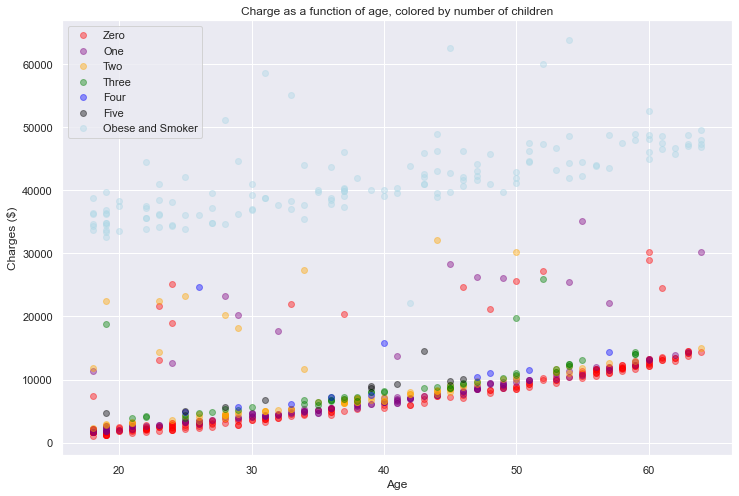

In [112]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.scatter(healthy_age_vector[zero_children_boolean], healthy_charge_vector[zero_children_boolean], c = 'red', label='Zero', alpha = 0.4)
plt.scatter(healthy_age_vector[one_children_boolean], healthy_charge_vector[one_children_boolean], c= 'purple', label='One', alpha = 0.4)
plt.scatter(healthy_age_vector[two_children_boolean], healthy_charge_vector[two_children_boolean], c= 'orange', label='Two', alpha = 0.4)
plt.scatter(healthy_age_vector[three_children_boolean], healthy_charge_vector[three_children_boolean], c= 'green', label='Three', alpha = 0.4)
plt.scatter(healthy_age_vector[four_children_boolean], healthy_charge_vector[four_children_boolean], c= 'blue', label='Four', alpha = 0.4)
plt.scatter(healthy_age_vector[five_children_boolean], healthy_charge_vector[five_children_boolean], c= 'black', label='Five', alpha = 0.4)
plt.scatter(age_vector[smoker_obese_boolean], charge_vector[smoker_obese_boolean], c = 'lightblue', label='Obese and Smoker', alpha = 0.4)
plt.xlabel('Age')
plt.ylabel('Charges ($)')
plt.title('Charge as a function of age, colored by number of children')
plt.legend()
plt.show()

The obese and smokers have been added into the plot to provide scale. Children cannot explain all of the middle band.

Let us simply quantify the change in charges for each group of number of children compared to the entire data set.

In [113]:
nums = list(range(6))
mean_charge = df['charges'].mean()
for i in nums:
    x = child_df['charges'][i]
    s = ''
    if x > mean_charge:
        s = 'more'
        p = x/mean_charge*100-100
    else:
        s = 'less'
        p = 100-x/mean_charge*100
    print('People with {} children pay {:.2f}% {} than average'.format(i,p,s))


People with 0 children pay 6.82% less than average
People with 1 children pay 4.06% less than average
People with 2 children pay 13.59% more than average
People with 3 children pay 15.71% more than average
People with 4 children pay 4.37% more than average
People with 5 children pay 33.79% less than average


Why do people with 5 children pay so much less? Lets take a look at their health statuses.

In [114]:
five_children_df = df[df['children'] == 5]
print(five_children_df['smoker'].value_counts(normalize=True))
print(five_children_df['BMI_Tier'].value_counts(normalize=True))

no     0.944444
yes    0.055556
Name: smoker, dtype: float64
Obese          0.388889
Overweight     0.277778
Healthy        0.277778
Underweight    0.055556
Name: BMI_Tier, dtype: float64


So we see that the that the proportion of smokers and obese people in the subset of the data with people with 5 children is less than the general population. As smoking is a major factor in increasing insurance, this explains the lower insurance charges for people with 5 children.

We are still struggling to explain the higher charges paid by some of the people in the middle band, who are not smokers, are not obese and don't have an expensive number of children. Could it be some combination of variables we previously ignored, such as location and gender?

## Finding the missing link

In this section we will investigate combinations of the variables we previously ignored to try and explain some anomalies in the data. We want to focus on those who don't smoke and are not obese, so we will remove these from the set for the next part of the investigation.
First lets combine gender and region.


In [115]:
healthy_df.groupby(['sex']).mean()

,age,bmi,children,charges
sex,,,,
female,38.686792,25.642774,1.026415,8278.665195
male,37.147679,25.458017,1.118143,7639.757563


In [116]:
healthy_df.groupby(['region']).mean()

,age,bmi,children,charges
region,,,,
northeast,37.559441,25.108566,1.076923,8276.994510
northwest,38.147887,25.249930,1.035211,8045.629956
southeast,38.318182,26.471250,1.147727,7807.226978
southwest,37.953488,25.762791,1.046512,7684.830825


In [234]:
healthy_df.groupby(['sex','region']).mean()

age        bmi  children      charges
sex    region                                                
female northeast  38.646154  24.841769  0.892308  8552.142237
       northwest  39.871429  25.172286  1.085714  8385.164766
       southeast  38.690909  26.932000  1.163636  8284.881861
       southwest  37.613333  25.830667  0.986667  7937.693271
male   northeast  36.653846  25.330897  1.230769  8047.704738
       northwest  36.472222  25.325417  0.986111  7715.526668
       southeast  37.696970  25.703333  1.121212  7011.135505
       southwest  38.425926  25.668519  1.129630  7333.632984

In [130]:
healthy_df.groupby(['sex','region']).count()

age  bmi  children  smoker  charges  BMI_Tier
sex    region                                                  
female northeast   65   65        65      65       65        65
       northwest   70   70        70      70       70        70
       southeast   55   55        55      55       55        55
       southwest   75   75        75      75       75        75
male   northeast   78   78        78      78       78        78
       northwest   72   72        72      72       72        72
       southeast   33   33        33      33       33        33
       southwest   54   54        54      54       54        54

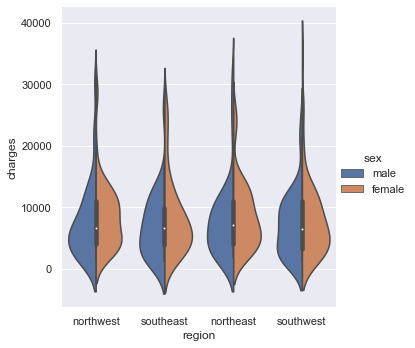

In [118]:
sns.catplot(data=healthy_df, kind = 'violin', x = 'region', y = 'charges', hue='sex', split = True)

From these quick looks it appears that healthy females pay slightly more than healthy men, and that region can indeed play a part, as healthy females in the northest and southeast appear to have some anomolous higher charges. Lets first check if gender creates a significant different for healthy people.

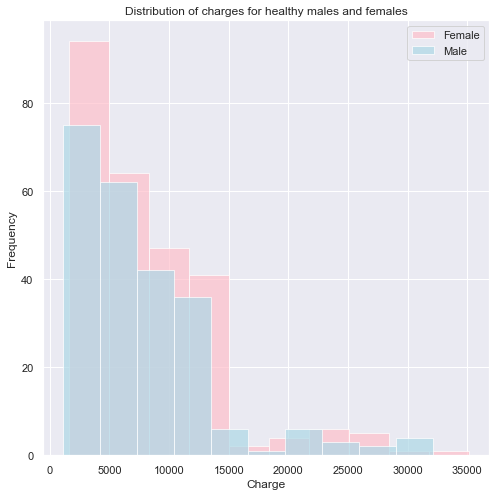

In [158]:
healthy_female_charges = healthy_df[(healthy_df['sex'] == 'female')]['charges']
healthy_male_charges = healthy_df[healthy_df['sex'] == 'male']['charges']
plt.hist(healthy_female_charges, label= 'Female', color = 'pink', alpha = 0.7)
plt.hist(healthy_male_charges, label= 'Male', color = 'lightblue', alpha = 0.7)
plt.legend()
plt.xlabel('Charge')
plt.ylabel('Frequency')
plt.title("Distribution of charges for healthy males and females")
plt.show()

Not normally distributed, will use Mann-Whitney U stat to ascertain significance. A one-sided test, null hypothesis the distributions have the same location, alternate hypothesis the mean of the female distribution is larger.

In [142]:
stats.mannwhitneyu(healthy_female_charges,healthy_male_charges, alternative = 'greater') 

MannwhitneyuResult(statistic=34697.0, pvalue=0.021169462568750887)

With $p=0.02$ we can reject the null hypothesis, and hence sex is a significant factor for healthy people when determining insurance charges.

Continuing in this manner we risk over analysing the data. Now is a good time to consider factors that we may not have information about. For example, people who have previously claimed health insurance will pay higher charges, or people who live in dangerous areas, or work in physically taxing jobs, and sadly we have no data on that fact. Working with what we have so far, we will try to build a model that can predict insurance prices from a selection of features.

## Predictive Model

In our analysis we have found the variables that have a strong relationship with insurance charges. In this section we will attempt to train a model to predict insurance charges.

First we need to do some feature engineering, we will turn all the  informative variables we found above into useable features for a regression model.

## Feature Engineering

In our analysis, we found that age, children, smoking status and bmi status (obese or not) were good predictors of charges.
Age played a key role in increasing the minimum charge, while obesity, smoking status and having 2 or 3 kids could explain some increases, and people who smoke and are obese payed far higher rates than anyone else.
We need to turn these all into features that a regression model can interpret and train on.
For the categorical variables we will create binary dummies, and drop one of each to avoid collinearity. Our predictors will also be min-max normalised to give all variables the same scale, as well as enable the use of non-invariant models later (ridge regression etc).
We do not standardise as our predictors are not normally distributed, and our binary variables are either 0 or 1. We will note that this will lead to the use of 0 age or bmi as a predictor, which will hinder interpretability later.

In [226]:
# First select the important variables
reg_df = df[['age','bmi','smoker','children', 'sex', 'region']]
# Add a column of booleans denoting if the person is a smoker and obese, or if they are healthy and female
reg_df['obese and smoker'] = (reg_df['smoker'] == 'yes' ) & (reg_df['bmi'] > 30)
reg_df['obese and smoker'] = reg_df['obese and smoker'].apply(int)
# reg_df['female and healthy'] = (reg_df['smoker'] == 'no' ) & (reg_df['bmi'] < 30) & (reg_df['sex'] == 'female')
# reg_df['female and healthy'] = reg_df['female and healthy'].apply(int)
# reg_df['male and healthy'] = (reg_df['smoker'] == 'no' ) & (reg_df['bmi'] < 30) & (reg_df['sex'] == 'male')
# reg_df['male and healthy'] = reg_df['male and healthy'].apply(int)
# reg_df['male'] = reg_df['sex'] == 'male'
# reg_df['male'] = reg_df['male'].apply(int)
# Normalise bmi and age
reg_df['bmi'] = (reg_df['bmi'] - reg_df['bmi'].min())/(reg_df['bmi'].max() - reg_df['bmi'].min())
reg_df['age'] = (reg_df['age'] - reg_df['age'].min())/(reg_df['age'].max() - reg_df['age'].min())
# Create vector for the target, charges
y = df['charges']
# Create dummy arrays for our categorical variables, dropping first to remove unnecessary features
# smoker_dummies = pd.get_dummies(reg_df['smoker'], drop_first=True)
children_dummies = pd.get_dummies(reg_df['children'], drop_first=True)
location_dummies = pd.get_dummies(reg_df['region'], drop_first=True)
# smoker_and_obese_dummies = pd.get_dummies(reg_df['obese and smoker'], drop_first=True).to_numpy()
# female_and_healthy_dummies = pd.get_dummies(reg_df['female and healthy'], drop_first=True).to_numpy()
# Change these columns to the dummy (binary) version
# reg_df['obese and smoker'] = smoker_and_obese_dummies
reg_df['smoker'] = reg_df['smoker'] == 'yes'
reg_df['smoker'] = reg_df['smoker'].apply(int)
# reg_df['smoker'] = smoker_dummies
# reg_df['female and healthy'] = female_and_healthy_dummies
# Drop the now obsolete children column 
reg_df = reg_df.drop(columns = ['children', 'sex', 'region'])
# Add the children dummy columns
children_dummies.columns = ['1 child', '2 children', '3 children','4 children','5 children' ]
# X = reg_df.join([ location_dummies])
X = reg_df.join([ children_dummies, location_dummies])
# Create a column of ones for the intercept
ones_col = np.ones((len(y), 1))
# Generate a list of feature names
feature_names = ['Intercept']
feature_names.extend(list(X.columns))
# Convert our data to a numpy array and add the column of ones
X = X.to_numpy()
X = np.hstack( (ones_col, X))
print(feature_names)
print(X)

['Intercept', 'age', 'bmi', 'smoker', 'obese and smoker', '1 child', '2 children', '3 children', '4 children', '5 children', 'northwest', 'southeast', 'southwest']
[[1.         0.02173913 0.3212268  ... 0.         0.         1.        ]
 [1.         0.         0.47914985 ... 0.         1.         0.        ]
 [1.         0.2173913  0.45843422 ... 0.         1.         0.        ]
 ...
 [1.         0.         0.56201238 ... 0.         1.         0.        ]
 [1.         0.06521739 0.26472962 ... 0.         0.         1.        ]
 [1.         0.93478261 0.35270379 ... 1.         0.         0.        ]]


We now have a data set ready to train a model. We will do a 50-25-25 train-vali-test split. This will allow us to tune hyper-parameters in later models.

In [227]:
X_tv, X_test, y_tv, y_test = tts(X, y, test_size=0.25, random_state = 0)
X_train, X_vali, y_train, y_vali = tts(X_tv, y_tv, test_size=1/3, random_state = 0)

### SIMPLE LINEAR MODEL

We first begin with a OLS model, the simpler the better.

In [228]:
linear_reg = LR()
linear_reg.fit(X_train, y_train)

pred_train = linear_reg.predict(X_train)
pred_vali = linear_reg.predict(X_vali)

mse_train = mse(pred_train, y_train)
mse_vali = mse(pred_vali, y_vali)
mae_vali = mae(pred_vali, y_vali)


print('Train mse: {:.2f}'.format(mse_train))
print('Validation mse: {:.2f}'.format(mse_vali))
print('Validation mae: {:.2f}'.format(mae_vali))
print('Average insurance charge {:.2f}'.format(mean_charge))

Train mse: 21445546.20
Validation mse: 21186794.22
Validation mae: 2562.40
Average insurance charge 13270.42


We have a rather large mean squared error, but the mean average error isn't too large compared to the average charge (~20%). Lets have a look at our predicted versus average values to see where we are going wrong.

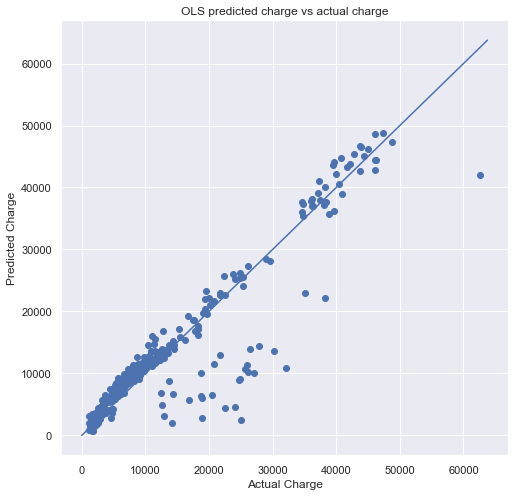

In [229]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.scatter(y_vali, pred_vali)
plt.plot(list(range(int(y.max()))),list(range(int(y.max()))))
plt.xlabel('Actual Charge')
plt.ylabel('Predicted Charge')
plt.title('OLS predicted charge vs actual charge')
plt.show()

Our model does very well for most points in the data set, yet we are under estimating the charge for a large group of entires, as well the largest charge in the set, which is a cause of our large mse. There is a good chance that our model is predicting a lower charge for the people who were in the middle band of the 'Charge as a function of age, colored by smoking and obesity status' plot that were neither smokers nor obese, as we could not identify a cause for their higher charges, and so none of the features in our set will be good predictors of their higher charges. We also see a slight deviation for lower charges, this is most likely due to the nonlinear relationship between age and charges, that our model cannot capture.

In [230]:
linear_SVR = LinearSVR(random_state=0, tol=1e-05, loss = 'squared_epsilon_insensitive', epsilon = 1, C = 10000/2, max_iter = 100000)
linear_SVR.fit(X_train, y_train)

pred_train = linear_SVR.predict(X_train)
pred_vali = linear_SVR.predict(X_vali)

mse_train = mse(pred_train, y_train)
mse_vali = mse(pred_vali, y_vali)
mae_vali = mae(pred_vali, y_vali)


print('Train mse: {:.2f}'.format(mse_train))
print('Validation mse: {:.2f}'.format(mse_vali))
print('Validation mae: {:.2f}'.format(mae_vali))
print('Average insurance charge {:.2f}'.format(mean_charge))

Train mse: 21541747.50
Validation mse: 21417131.62
Validation mae: 2471.82
Average insurance charge 13270.42


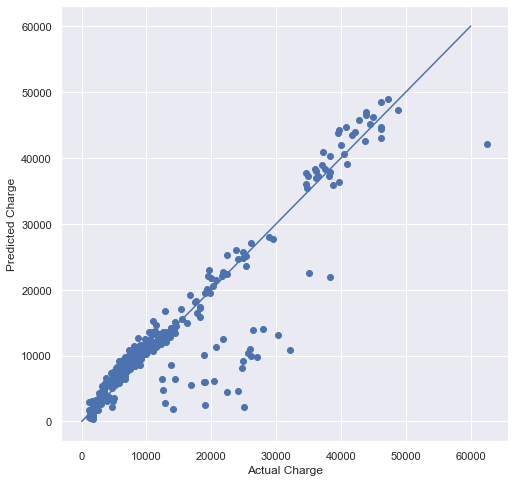

In [231]:
plt.scatter(y_vali, pred_vali)
# plt.scatter(y_vali[X_vali['yes'] == 1], pred_vali[X_vali['yes'] == 1], c = 'red')
plt.plot(list(range(60000)),list(range(60000)))
plt.xlabel('Actual Charge')
plt.ylabel('Predicted Charge')
plt.show()

In [232]:
SVR_mod = SVR(C = 100000, epsilon=1)
SVR_mod.fit(X_train, y_train)

pred_train = SVR_mod.predict(X_train)
pred_vali = SVR_mod.predict(X_vali)

mse_train = mse(pred_train, y_train)
mse_vali = mse(pred_vali, y_vali)
mae_vali = mae(pred_vali, y_vali)


print('Train mse: {:.2f}'.format(mse_train))
print('Validation mse: {:.2f}'.format(mse_vali))
print('Validation mae: {:.2f}'.format(mae_vali))
print('Average insurance charge {:.2f}'.format(mean_charge))

Train mse: 21719616.04
Validation mse: 21854548.90
Validation mae: 1662.80
Average insurance charge 13270.42


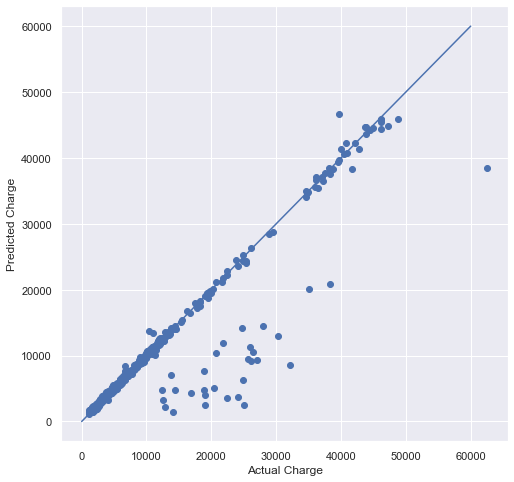

In [233]:
plt.scatter(y_vali, pred_vali)
# plt.scatter(y_vali[X_vali['yes'] == 1], pred_vali[X_vali['yes'] == 1], c = 'red')
plt.plot(list(range(60000)),list(range(60000)))
plt.xlabel('Actual Charge')
plt.ylabel('Predicted Charge')
plt.show()

In [50]:
print(linear_SVR.coef_)

[12308.65467107  2070.7196231  19870.34261443 13687.1503995
   811.15424406  1803.15883867  1039.36192232  3625.3365102
   697.69617795   546.87052166]


# SUMMARY AND CONCLUSIONS

# Extra stuff: removed from main but saved for later if needed


## OBESE AND SMOKER

As a last investigation, lets compare those who are obese and smoke to the rest of the set


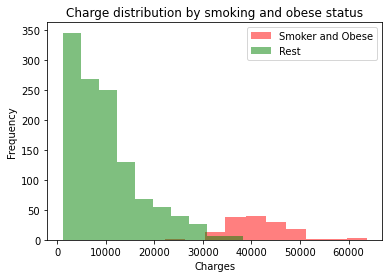

In [ ]:
smoke_obese = smoking_boolean & obese_boolean
rest = nonsmoking_boolean | nonobese_boolean
plt.hist(charge_vector[smoke_obese],color ='red', alpha = 0.5, label = 'Smoker and Obese')
plt.hist(charge_vector[rest],color ='green', alpha = 0.5, label = 'Rest')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.title('Charge distribution by smoking and obese status')
plt.legend()
plt.show()

In [ ]:
print('Increase in charges for those who smoke and are obese: {:.2f} %'.format(charge_vector[smoke_obese].mean()/charge_vector[rest].mean()*100 - 100))
stats.ttest_ind(charge_vector[smoke_obese], charge_vector[rest], alternative = 'greater')

Increase in charges for those who smoke and are obese: 322.67 %


Ttest_indResult(statistic=51.34519192347729, pvalue=1.007667e-318)

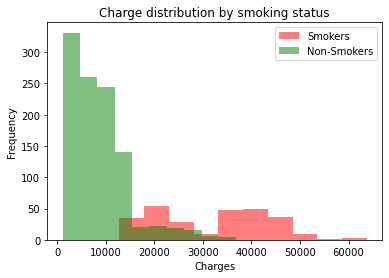

In [13]:
smoker_charges = df[ df['smoker'] == 'yes']['charges'].to_numpy()
nonsmoker_charges = df[ df['smoker'] == 'no']['charges'].to_numpy()
plt.hist(smoker_charges,color ='red', alpha = 0.5, label = 'Smokers')
plt.hist(nonsmoker_charges,color ='green', alpha = 0.5, label = 'Non-Smokers')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.title('Charge distribution by smoking status')
plt.legend()
plt.show()

In [ ]:
age_df = df.groupby('age', as_index = False).mean()
a18_25 = age_df[ ( age_df['age'] >= 18 ) & ( age_df['age'] <= 25)].mean(axis = 0).charges
a26_35 = age_df[ ( age_df['age'] >= 26 ) & ( age_df['age'] <= 35)].mean(axis = 0).charges
a36_45 = age_df[ ( age_df['age'] >= 36 ) & ( age_df['age'] <= 45)].mean(axis = 0).charges
a46_55 = age_df[ ( age_df['age'] >= 46 ) & ( age_df['age'] <= 55)].mean(axis = 0).charges
a56p =  age_df[ age_df['age']>= 56].mean(axis = 0).charges
age_split = [a18_25, a26_35,a36_45, a46_55, a56p]
age_split_labels = [r'18-25', r'26-35',r'36-45',r'46-55',r'56+']
plt.bar(age_split_labels, age_split)

In [ ]:
# plt.scatter(y_vali[X_vali['Smoker'] == 1], pred_vali[X_vali['yes'] == 1], c = 'red')
# ( (healthy_df['region'] == 'northeast'  ) | (healthy_df['region'] == 'southest' )    )

In [160]:
int(False)

0